In [1]:
import numpy as np

from sklearn.metrics import confusion_matrix
from hmmlearn import hmm

import gzip
import itertools
import pickle
import time

import matplotlib.pyplot as plt

%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-w3y1t4go because the default path (/home/lipinski/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def hill_curve_001(x):
    # return 0.185 + (0.867-0.185)*x**1.18 / (68.0**1.18 + x**1.18)
    return 0.168 + (1.07-0.168)*x**0.792 / (112.0**0.792 + x**0.792)

In [3]:
def make_plots(Z, Z_hat):
    order = Z.argsort()

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,2), sharey=True)
    ax1.imshow(Z[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z.shape[0] - 0.5, 0, 1), cmap="jet")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.imshow(Z_hat[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat.shape[0] - 0.5, 0, 1), cmap="jet")
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.show()

    cm = confusion_matrix(Z, Z_hat)

    cm_best_ = cm.copy()
    cm_best_a_ = np.diag(cm_best_).sum()
    for p in itertools.permutations(np.arange(cm.shape[0])):
        cm_ = cm[p, :].copy()
        cm_a_ = np.diag(cm_).sum()
        if cm_a_ > cm_best_a_:
            cm_best_ = cm_.copy()
            cm_best_a_ = cm_a_
    print(cm_best_)
    print(cm_best_a_ / cm_best_.sum())

## Generating Data

In [4]:
K = 3
T = 500000

model_1 = hmm.GaussianHMM(n_components=K, covariance_type="diag")

model_1.startprob_ = np.array([0.6, 0.3, 0.1])
model_1.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.1, 0.8, 0.1],
                            [0.05, 0.05, 0.9]])
model_1.means_ = np.array([[0.0], [50.0], [100.0]])
model_1.covars_ = np.tile(np.ones(1), (K, 1))

X, Z = model_1.sample(T)

# f = gzip.open('data_hmm_004.pcklz', 'wb')
# pickle.dump(X, f)
# pickle.dump(Z, f)
# f.close()

t = 7

X_ = X.copy()
X_ = X_.cumsum()
X_ = (X_[t:] - X_[:-t])
X_ = hill_curve_001(X_+10)

X, Z = X_.reshape(-1, 1), Z[t:]

X[np.isnan(X)] = 0.00

f = gzip.open('data_hmm_004a.pcklz', 'wb')
pickle.dump(X, f)
pickle.dump(Z, f)
f.close()

/tmp/ipykernel_2361331/913686053.py:3: RuntimeWarning: invalid value encountered in power
  return 0.168 + (1.07-0.168)*x**0.792 / (112.0**0.792 + x**0.792)


## Regular HMM

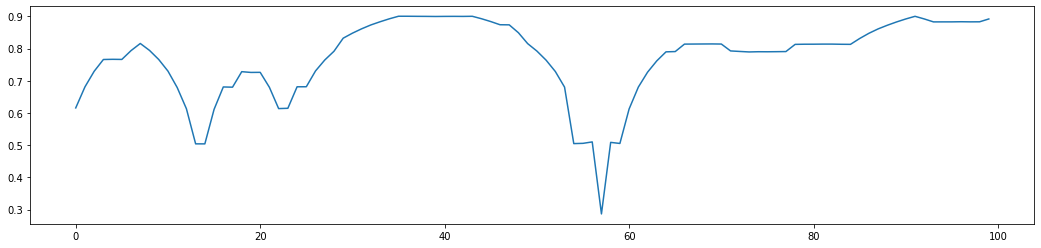

17.009414434432983


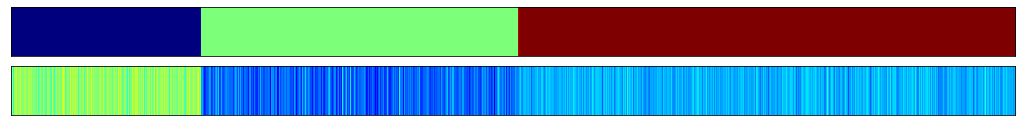

[[122333      0  35605]
 [107294 131307   8971]
 [ 45057      0  49426]]
0.6061404859668036


In [5]:
f = gzip.open('data_hmm_004a.pcklz', 'rb')
X = pickle.load(f)
Z = pickle.load(f)
f.close()

plt.figure(figsize=(18,4))
plt.plot(X[:100])
plt.show()

model_r = hmm.GaussianHMM(n_components=K, covariance_type="diag", n_iter=10000, tol=0.0001)
t0 = time.time()
model_r = model_r.fit(X)
print(time.time() - t0)
Z_hat = model_r.predict(X)

make_plots(Z, Z_hat)

## Gaussian Dense HMM

In [6]:
from models_gaussian_2d import GaussianDenseHMM
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

2022-12-03 22:13:22.511199: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 22:13:22.511233: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
def compute_stationary(M, verbose=True):
    eigval, eigvec = np.linalg.eig(M.T)
    idx = np.asarray(np.isclose(eigval, [1.], rtol=1e-2, atol=1e-3)).nonzero()[0]
    if idx.size < 1:
        raise Exception("No Eigenvalue 1")
    elif idx.size > 1 and verbose:
        print("Warning: Multiple vectors corresponding to eigenvalue 1.: %s" % str(idx))
    M_stationary = eigvec[:, idx[0]].real
    M_stationary = M_stationary / np.sum(M_stationary)
    return M_stationary

def relu(x):
    return x * (x > 0)

def compute_loss(nodes, splits, n_, omega_gt, means_, covars_, A_):
    B_scalars = None
    if d == 1:  # popraw wizualnie
        B_scalars_tmp = .5 * (
                1 + erf((nodes - np.transpose(a=means_)) / (
                relu(np.transpose(a=covars_[:, :, 0])) + 1e-10) / np.sqrt(2)))

        B_scalars = np.transpose(a=B_scalars_tmp[1:, :] - B_scalars_tmp[:-1, :])
    if d == 2:
        B_scalars_tmp = np.prod(.5 * (
                1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(
            np.transpose(a=means_), axis=0)) / (
                                relu(np.expand_dims(np.transpose(np.array(list(map(lambda x: np.diag(np.array(x)), covars_.tolist())))), axis=0)) + 1e-10) / np.sqrt(2))), axis=1)

        # B_scalars_tmp = np.prod(input_tensor=.5 * (
        #                     1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(
        #                 np.transpose(means_), axis=0)) / (relu(np.expand_dims(np.transpose(covars_),
        #                                                                       axis=0)) + 1e-10) / np.sqrt(2))), axis=1)

            # np.prod(.5 * (
            #     1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(np.transpose(a=means_), axis=0)) /
            #             (relu(np.expand_dims(np.transpose(np.array(list(map(lambda x: np.diag(np.array(x)), covars_.tolist())))), axis=0)) + 1e-10) /
            #             np.sqrt(2))), axis=1)
        B_scalars_tmp_wide = np.reshape(B_scalars_tmp, (*[n.shape[0] for n in splits], n_))
        B_scalars = np.transpose(a=np.reshape(
            B_scalars_tmp_wide[:-1, 1:, :] - B_scalars_tmp_wide[:-1, :-1, :] - B_scalars_tmp_wide[1:, 1:,
                                                                               :] + B_scalars_tmp_wide[1:, :-1, :],
            (-1, n_)))

    A_stationary = compute_stationary(A_, verbose=False)

    theta = A_ * A_stationary[:, None]
    omega = np.matmul(np.transpose(a=B_scalars), np.matmul(theta, B_scalars))
    loss_cooc = np.sum(np.abs(omega_gt - omega)) / 2
    return loss_cooc

def provide_nodes(n_, Y_train):
    kmeans = KMeans(n_).fit(Y_train)
    dtree = DecisionTreeClassifier().fit(Y_train, kmeans.labels_)

    splits = np.concatenate([dtree.tree_.feature.reshape(-1, 1), dtree.tree_.threshold.reshape(-1, 1)], axis=1)
    splits = np.concatenate([splits, np.array([[i, fun(Y_train[:, i])] for i, fun in itertools.product(range(Y_train.shape[1]), [
        lambda x: np.min(x) - 1e-3, lambda x: np.max(x) + 1e-3])])])
    splits = splits[splits[:, 0] >= 0]

    nodes_x = [np.sort(splits[splits[:, 0] == float(i), 1]) for i in np.unique(splits[:, 0])]
    nodes = np.array([t for t in itertools.product(*nodes_x)])

    splits = nodes_x  # number  of splits  on each axis
    discrete_nodes = nodes.astype('float32')
    discrete_observables = [n.shape[0] - 1 for n in nodes_x]

    indexes = np.arange(np.prod(discrete_observables)).reshape(discrete_observables)  # .transpose()
    Y_train_disc = np.array([indexes[i] for i in
                       zip(*[(Y_train[:, j].reshape(-1, 1) > splits[j].reshape(1, -1)).sum(axis=1) - 1 for j in
                             range(len(splits))])])

    return nodes, nodes_x, Y_train_disc

def _lengths_iterator(seqs, lengths):
    n_seqs = len(lengths)
    left, right = 0, 0

    for i in range(len(lengths)):
        right += lengths[i]
        yield seqs[left:right]
        left += lengths[i]

def empirical_coocs(seqs, m, lengths=None):
    freqs = np.zeros((m, m))
    seq_iterator = seqs
    if lengths is not None:
        seq_iterator = _lengths_iterator(seqs, lengths)

    for seq in seq_iterator:

        if seq.shape[0] <= 1:  # no transitions
            continue

        seq = seq.reshape(-1)

        seq_pairs = np.dstack((seq[:-1], seq[1:]))
        seq_pairs, counts = np.unique(seq_pairs, return_counts=True, axis=1)
        seq_pre, seq_suc = [arr.flatten() for arr in np.dsplit(seq_pairs, 2)]
        freqs[seq_pre, seq_suc] += counts

    return freqs, freqs / np.sum(freqs)

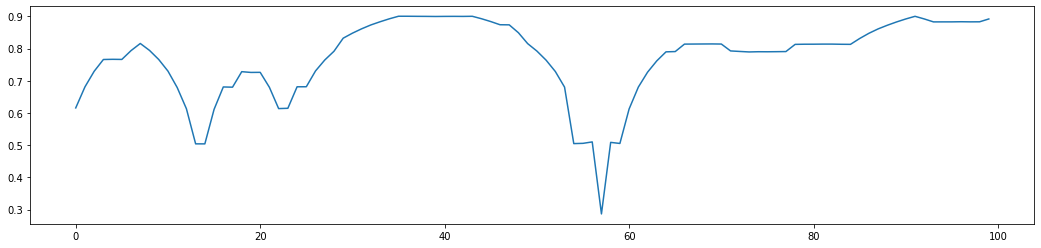

2022-12-03 22:13:56.329897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 22:13:56.334488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 22:13:56.338210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-03 22:13:56.341635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-03 22:13:56.345011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

inf


         2      152052.3484     +629558.3656


inf


         3     -627584.8479     -779637.1963


inf


         4     -760581.5368     -132996.6889


inf


         5    -1877200.1449    -1116618.6082


inf


         6     -986450.7255     +890749.4194


inf


         7    -2013552.4095    -1027101.6840


inf


         8    -2054963.3789      -41410.9695


inf


         9    -2002730.1087      +52233.2703


inf


        10    -1999868.1606       +2861.9481


inf


        11    -1571584.7102     +428283.4504


inf


        12    -1904380.2627     -332795.5526


inf


        13    -1528295.2249     +376085.0378


inf


        14    -1977346.8297     -449051.6048


inf


        15    -1992371.8861      -15025.0564


inf


        16    -2065964.4810      -73592.5949


inf


        17    -1414666.2950     +651298.1860


inf


        18    -1966807.9877     -552141.6927


inf


        19    -1594378.4045     +372429.5832


inf


        20    -1558988.9932      +35389.4114


inf


        21    -1687033.4292     -128044.4360


inf


        22    -1817892.8283     -130859.3991


inf


        23    -1817754.0907        +138.7376


inf


        24    -1725058.0223      +92696.0684


inf


        25    -1876760.1945     -151702.1722


inf


        26    -1825599.1530      +51161.0415


inf


        27    -1869152.1671      -43553.0141


inf


        28    -1833234.7570      +35917.4101


inf


        29    -1852329.7037      -19094.9467


inf


        30    -1999520.7922     -147191.0885


inf
28.16254210472107


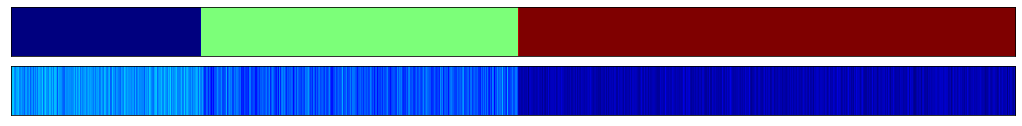

[[     0  68848  25635]
 [     0 236090  11482]
 [     0 125668  32270]]
0.5367275141851986


In [8]:
f = gzip.open('data_hmm_004a.pcklz', 'rb')
X = pickle.load(f)
Z = pickle.load(f)
f.close()

plt.figure(figsize=(18,4))
plt.plot(X[:100])
plt.show()

n = 3
d = 1
Y = X
lengths = np.array([Y.shape[0]])

nodes, splits, Y_disc = provide_nodes(n, Y)
_, omega_gt = empirical_coocs(Y_disc.reshape(-1, 1), np.max(Y_disc) + 1, lengths=lengths)
model = GaussianDenseHMM(n_hidden_states=n, mstep_config={'cooc_epochs': 10000 * n, 'cooc_lr': 0.002, 'loss_type': 'abs'}, n_dims=d,
                         verbose=True, early_stopping=True, convergence_tol=0.0001, covariance_type='diag')
t0 = time.time()
model.fit_coocs(Y, lengths)
print(time.time() - t0)
Z_hat = model.predict(Y, lengths)

make_plots(Z, Z_hat)